# Predicting Time-Lagged Interactions Using PICRUSt-Generated Genomes

In [207]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import shap

In [97]:
topN = 30

myinteractions = pd.read_csv('/home/operon/Documents/lag_regress/sig_interactions.txt', sep=' ')
mydiffs = pd.read_csv('/home/operon/Documents/lag_regress/genome_diffs.txt', sep=' ')
mykoNames = pd.read_csv('/home/operon/Documents/For_Casey/ko_names_clean.tsv', sep='\t', header=None)
mykoNames.columns = ['ko_id', 'ko_name']

mydiffs = pd.get_dummies(mydiffs)
interaction_type = myinteractions['r_coef'] > 0

### Model Training and Cross Validation

In [72]:
kf = KFold(n_splits=3)
kf.get_n_splits(mydiffs)

allPred = []
allAnswers = []
scores = []

for train_index, test_index in kf.split(mydiffs):
    X_train, X_test = mydiffs.iloc[train_index], mydiffs.iloc[test_index]
    y_train, y_test = interaction_type[train_index], interaction_type[test_index]
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=5000, n_jobs=8)
    clf.fit(X_train, y_train)
    yPred = list(clf.predict(X_test))
    allPred += yPred
    allAnswers += list(y_test)
    scores.append(accuracy_score(y_test, yPred))

### Identify Informative Features

In [113]:
topFeatures = clf.feature_importances_.argsort()[-topN:][::-1]
topFeaturesKoId = []
for i in mydiffs.columns[topFeatures]:
    topFeaturesKoId.append(i[:-2])

### Generate Distribution of Null Model Accuracies via Permutation of Interaction Labels
Notice: This step is computationally intensive

In [ ]:
kf = KFold(n_splits=3)
kf.get_n_splits(mydiffs)

allPredNull = []
allAnswersNull = []
allScoresNull = []
interaction_type_shuff = np.array(interaction_type)

for i in range(300):
    for train_index, test_index in kf.split(mydiffs):
        np.random.shuffle(interaction_type_shuff)
        X_train, X_test = mydiffs.iloc[train_index], mydiffs.iloc[test_index]
        y_train, y_test = interaction_type_shuff[train_index], interaction_type_shuff[test_index]

        clf_null = RandomForestClassifier(max_depth=5, n_estimators=5000, n_jobs=-1)
        clf_null.fit(X_train, y_train)
        yPred = list(clf.predict(X_test))
        allPredNull += yPred
        allAnswersNull += list(y_test)
        allScoresNull.append(accuracy_score(y_test, yPred))

### Visualize Distribution of Null Model Accuracies

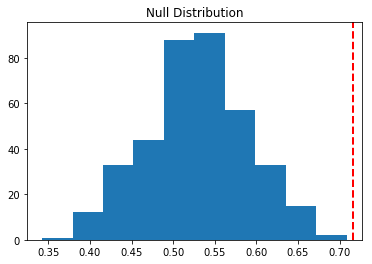

('Min: ', 0.34246575342465752, 'Max: ', 0.70833333333333337, 'Mean: ', 0.5299546212636419)
('Empirical Mean: ', 0.71556316590563174)


In [123]:
plt.title('Null Distribution')
plt.hist(allScoresNull, bins=10)
plt.axvline(np.mean(scores), color='r', linestyle='dashed', linewidth=2)
plt.show()
print('Min: ', np.min(allScoresNull), 'Max: ', np.max(allScoresNull), 'Mean: ', np.mean(allScoresNull))
print('Empirical Mean: ', np.mean(scores))

### Informative Features
High abundance of surface molecules and enzymes that generate periplasmic and membrane components.
 * porins, transporters, and channels
 * LPS/PG machinery
 * membrane modification

Metabolism signatures
 * starch and carbohydrate metabolism
 * vitamin and cofactor biosynthesis and acquisition

In [114]:
mykoNames[mykoNames['ko_id'].isin(topFeaturesKoId)]

,ko_id,ko_name
257,K06960,uncharacterized protein
565,K05807,outer membrane protein assembly factor BamD
585,K02066,phospholipid/cholesterol/gamma-HCH transport s...
1039,K00677,UDP-N-acetylglucosamine acyltransferase
1118,K03585,"membrane fusion protein, multidrug efflux system"
1375,K06861,lipopolysaccharide export system ATP-binding p...
1833,K04072,acetaldehyde dehydrogenase / alcohol dehydroge...
2232,K02527,3-deoxy-D-manno-octulosonic-acid transferase
2390,K06142,outer membrane protein
2452,K00016,L-lactate dehydrogenase


### LIME: Identifying Informative Features For a Specific Interaction

In [194]:
myinteractions.head()

,OTUi,OTUj,pvalue,r_coef,rand_r_coef,skew,kurt,sd,mean_tip_dist_i,mean_tip_dist_j,i_j_dist,anonymized_name
0,125624,1504042,0.007799,-0.428094,-0.281621,2.030159,7.794307,0.084622,0,0,0.42995,F01
1,1504042,4308835,0.003900,-0.310699,-0.153261,1.804511,6.432799,0.082215,0,0,0.19057,F01
2,164430,48084,0.000050,0.438666,0.183992,-0.109580,-0.344415,0.080530,0,0,0.61098,F01
3,173773,48084,0.003400,-0.354865,-0.160024,0.872692,3.233229,0.080981,0,0,0.52974,F01
4,173851,4478815,0.006299,0.279787,-0.088609,0.854845,2.278433,0.082435,0,0,0.50693,F01


In [140]:
predict_fn = lambda x: clf.predict_proba(x)
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train), feature_names = mydiffs.columns, 
                                                   class_names = interaction_type,
                                                   kernel_width=3, verbose=False)


### Negative Interaction Predictors

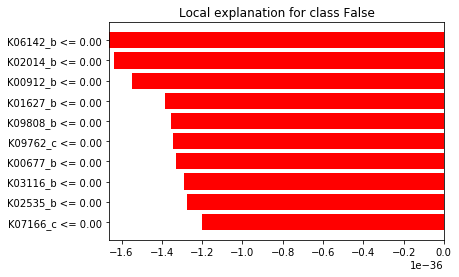

In [208]:
expNeg = explainer.explain_instance(np.array(X_train)[0], predict_fn, num_features=10)
expNeg.as_pyplot_figure()

### Positive Interaction Predictors

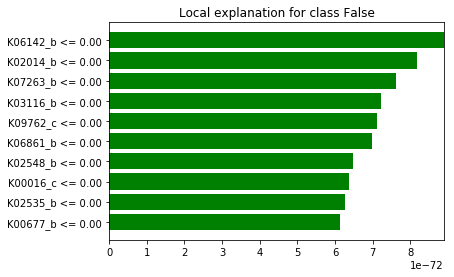

In [209]:
expPos = explainer.explain_instance(np.array(X_train)[2], predict_fn, num_features=10)
expPos.as_pyplot_figure()

In [218]:
mydiffs[mydiffs.columns[topFeatures]].head(n=20)

,K06142_b,K02014_b,K02535_b,K09762_c,K00912_b,K01627_b,K02527_b,K07277_b,K09808_b,K03327_b,...,K07263_b,K00677_b,K02548_b,K03585_b,K00016_c,K00946_b,K06960_c,K02536_b,K08307_b,K00965_c
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
myinteractions.head(n=20)

,OTUi,OTUj,pvalue,r_coef,rand_r_coef,skew,kurt,sd,mean_tip_dist_i,mean_tip_dist_j,i_j_dist,anonymized_name
0,125624,1504042,0.007799,-0.428094,-0.281621,2.030159,7.794307,0.084622,0,0,0.42995,F01
1,1504042,4308835,0.003900,-0.310699,-0.153261,1.804511,6.432799,0.082215,0,0,0.19057,F01
2,164430,48084,0.000050,0.438666,0.183992,-0.109580,-0.344415,0.080530,0,0,0.61098,F01
3,173773,48084,0.003400,-0.354865,-0.160024,0.872692,3.233229,0.080981,0,0,0.52974,F01
4,173851,4478815,0.006299,0.279787,-0.088609,0.854845,2.278433,0.082435,0,0,0.50693,F01
5,4478815,4481613,0.000600,-0.316257,-0.066351,-0.029737,0.073769,0.080787,0,0,0.61296,F01
6,176312,4423553,0.009899,-0.310639,-0.144756,0.594657,0.655204,0.083171,0,0,0.39166,F01
7,183829,4423553,0.004800,-0.343204,-0.161025,0.421031,0.388867,0.081489,0,0,0.11320,F01
8,2056702,3907189,0.008899,-0.223339,0.011685,0.090395,0.089156,0.082140,0,0,0.29756,F01
9,2056702,4308835,0.002700,-0.498712,-0.312251,0.305691,0.061933,0.074886,0,0,0.06844,F01
